In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns

In [ ]:
#imp function
def get_categorical_columns(df):
  l = list()
  for i in range(len(df.dtypes)):
    if(df.dtypes[i] == np.object):
      l.append(i)
  return l

In [ ]:
train_df = pd.read_csv("/content/intermediate_T1.csv")

In [ ]:
test_df = pd.read_csv("/content/intermediate_test.csv")

In [ ]:
train_df.shape

(1460, 76)

In [ ]:
test_df.shape

(1459, 75)

##Verification done

In [ ]:
l1 = list(train_df.columns)
l2 = list(test_df.columns)

In [ ]:
for i in range(len(l2)):
  if(l1[i]!=l2[i]):
    print(l1[i],l2[i]) 

#feature selection 

In [ ]:
train_df.drop(['Id'],axis=1, inplace=True)

In [ ]:
test_df.drop(['Id'],axis=1, inplace=True)

In [ ]:
train_df.head(5)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,0,12,2008,WD,Normal,250000


#spearman rank coeff

In [ ]:
corr = train_df.corr(method='spearman')

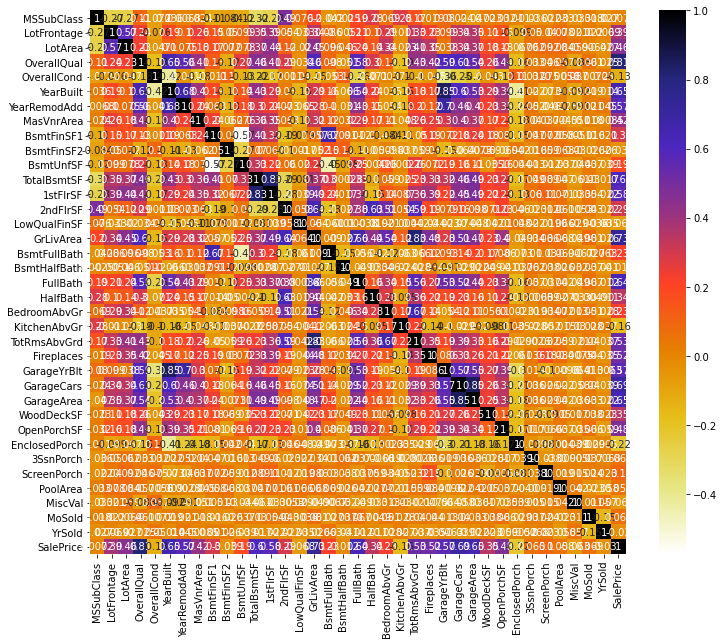

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,10))
sns.heatmap(corr, cmap=plt.cm.CMRmap_r, annot=True)

In [ ]:
def get_corr_features(df, threshold):
  arr = df.to_numpy()
  selected_features = set()
  for i in range(len(arr) ):
    for j in range( len(arr)):
      if(j>i):
        if(arr[i, j] >= threshold or arr[i, j] <=  -threshold ):
          selected_features.add(df.columns[j])

  return selected_features        


In [ ]:
to_drop = get_corr_features(corr, 0.7)

In [ ]:
to_drop

{'1stFlrSF', 'GarageArea', 'GarageYrBlt', 'SalePrice', 'TotRmsAbvGrd'}

In [ ]:
to_drop.remove('SalePrice')

In [ ]:
to_drop

{'1stFlrSF', 'GarageArea', 'GarageYrBlt', 'TotRmsAbvGrd'}

In [ ]:
train_df.drop(list(to_drop), axis=1, inplace=True)

In [ ]:
test_df.drop(list(to_drop), axis=1, inplace=True)

In [ ]:
train_df.shape

(1460, 71)

In [ ]:
test_df.shape

(1459, 70)

#Cramers V test

In [ ]:
import scipy.stats as stats

def get_cat_corr_df(df):
  #using cramers V test

  cat_corr = pd.DataFrame(columns = df.columns, 
                   index = df.columns)
  for i in range(df.shape[1]):
    for j in range(df.shape[1]):
      
      original = pd.crosstab(df.iloc[:,i],df.iloc[:,j])
      chi_square, p, dof, expected = stats.chi2_contingency(original.values)

      r,c = original.shape
      cV = np.sqrt(chi_square/(df.shape[0]*min(r-1,c-1)))
      cat_corr.iloc[i,j] = cV

  return cat_corr   



In [ ]:
categorical_index = get_categorical_columns(train_df)

In [ ]:
categorical_df = train_df.iloc[:,categorical_index]

In [ ]:
categorical_df.head()

,MSZoning,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,SaleType,SaleCondition
0,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,No,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,Attchd,RFn,TA,TA,Y,WD,Normal
1,RL,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,Gable,CompShg,MetalSd,MetalSd,None,TA,TA,CBlock,Gd,TA,Gd,ALQ,Unf,GasA,Ex,Y,SBrkr,TA,Typ,Attchd,RFn,TA,TA,Y,WD,Normal
2,RL,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,Mn,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,Attchd,RFn,TA,TA,Y,WD,Normal
3,RL,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,Gable,CompShg,Wd Sdng,Wd Shng,None,TA,TA,BrkTil,TA,Gd,No,ALQ,Unf,GasA,Gd,Y,SBrkr,Gd,Typ,Detchd,Unf,TA,TA,Y,WD,Abnorml
4,RL,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,Av,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,Attchd,RFn,TA,TA,Y,WD,Normal


In [ ]:
cat_corr = get_cat_corr_df(categorical_df)

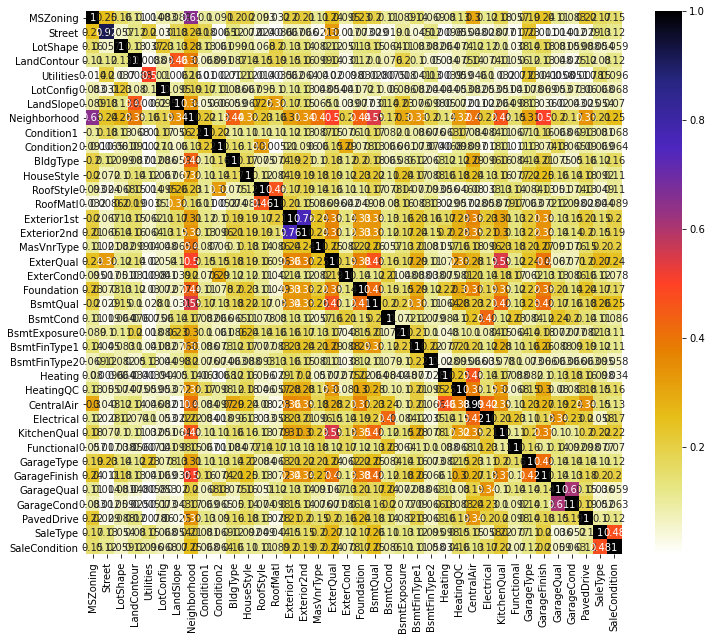

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,10))
sns.heatmap(cat_corr.astype(dtype=np.float64), cmap=plt.cm.CMRmap_r, annot=True)

In [ ]:
cat_corr.head(5)

,MSZoning,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,SaleType,SaleCondition
MSZoning,1,0.254738,0.160798,0.114652,0.0135648,0.0825034,0.0888189,0.65248,0.10275,0.09075,0.195389,0.196826,0.0934247,0.0316683,0.202875,0.211868,0.11124,0.244854,0.0946854,0.230856,0.196085,0.105391,0.0894982,0.142123,0.0692563,0.0799658,0.12812,0.301087,0.115481,0.181886,0.0573331,0.194945,0.236638,0.109993,0.0831151,0.224525,0.167906,0.147952
Street,0.254738,0.916323,0.0565316,0.122497,0.202933,0.0310497,0.180009,0.236371,0.180734,0.00654493,0.124016,0.0719132,0.0236823,0.00864979,0.0668527,0.0662319,0.0211775,0.324224,0.0168303,0.0733228,0.0293251,0.0185164,0.101546,0.0445849,0.122344,0.00961622,0.0552264,0.0481647,0.0280677,0.0765305,0.017419,0.228703,0.0114368,0.014198,0.0124676,0.0292443,0.133306,0.115378
LotShape,0.160798,0.0565316,1,0.134292,0.037177,0.226854,0.127173,0.275455,0.128089,0.0607895,0.0993261,0.100764,0.0683713,0.197978,0.127396,0.137698,0.0820553,0.120708,0.0512651,0.130324,0.146691,0.063785,0.113292,0.0827967,0.0815672,0.063697,0.0743572,0.116766,0.123855,0.102786,0.038326,0.143754,0.180203,0.0814297,0.0593426,0.0880229,0.0542944,0.0585721
LandContour,0.114652,0.122497,0.134292,1,0.008826,0.079609,0.45918,0.381687,0.0680559,0.0911504,0.0865073,0.143461,0.152131,0.193178,0.152042,0.157682,0.0986941,0.141208,0.0305843,0.116179,0.103926,0.0759231,0.197073,0.102972,0.0504286,0.0337748,0.0751672,0.136018,0.0735589,0.106958,0.05556,0.117275,0.132679,0.0482336,0.0251091,0.124931,0.0799818,0.122025
Utilities,0.0135648,0.202933,0.037177,0.008826,0.499657,0.0998007,0.00621965,0.160151,0.0104304,0.00266737,0.0116118,0.121284,0.0138428,0.00352521,0.0618239,0.0644114,0.039539,0.0204721,0.00975525,0.0298826,0.0278087,0.00754634,0.0180103,0.041335,0.133588,0.00391907,0.0588797,0.0461655,0.0998007,0.0319727,0.00709909,0.227996,0.0410596,0.00578638,0.00508116,0.00783449,0.150288,0.0960332


In [ ]:
to_drop_cat = get_corr_features(cat_corr,0.7)

In [ ]:
to_drop_cat

{'Exterior2nd'}

#now dropping those features both in train and test

In [ ]:
train_df.drop(list(to_drop_cat),axis=1,inplace=True)
test_df.drop(list(to_drop_cat),axis=1,inplace=True)

In [ ]:
train_df.shape

(1460, 70)

In [ ]:
test_df.shape

(1459, 69)

# getting arrays and splitting

In [ ]:
X = train_df.iloc[:,:-1].values
y = train_df.iloc[:,-1].values
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1)

In [ ]:
X_train.shape

(1168, 69)

In [ ]:
y_train.shape

(1168,)

#applying target encoding 

In [ ]:
!pip install category_encoders

In [ ]:
from category_encoders import TargetEncoder
#ecoding only the categorical columns

l = get_categorical_columns(train_df)
ec = TargetEncoder()
ec.fit(X_train[:,l],y_train)

X_train[:,l] = ec.transform(X_train[:,l])
X_test[:,l] = ec.transform(X_test[:,l])

/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


#training (random Forest)

In [ ]:
from sklearn.ensemble import RandomForestRegressor
regressor = RandomForestRegressor(n_estimators = 100, random_state = 0)
regressor.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=15, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=0, verbose=0, warm_start=False)

In [ ]:
y_pred = regressor.predict(X_test)

y_true = np.log10(y_test)
y_p = np.log10(y_pred)

from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(y_true, y_p))

print("root mean sqaured error is: ",rmse)

root mean sqaured error is:  0.06073965654070882


In [ ]:
X_sub = test_df.iloc[:,:].values

X_sub[:,l] = ec.transform(X_sub[:,l])

X_sub

array([[20, 138995.1885877117, 80.0, ..., 2010, 174148.50592885376,
        176411.80877742945],
       [20, 192467.20819848974, 81.0, ..., 2010, 174148.50592885376,
        176411.80877742945],
       [60, 192467.20819848974, 74.0, ..., 2010, 174148.50592885376,
        176411.80877742945],
       ...,
       [20, 192467.20819848974, 160.0, ..., 2006, 174148.50592885376,
        140526.93902439025],
       [85, 192467.20819848974, 62.0, ..., 2006, 174148.50592885376,
        176411.80877742945],
       [60, 192467.20819848974, 74.0, ..., 2006, 174148.50592885376,
        176411.80877742945]], dtype=object)

In [ ]:
sample_sub = regressor.predict(X_sub)
#dropped this id column now we have to take it from sample submission file
temp = pd.read_csv("/content/submission.csv")

final = pd.DataFrame({"Id":temp["Id"], "SalePrice": sample_sub})

In [ ]:
final.to_csv("/content/submission3_corr.csv", index=False)

In [ ]:
#train_df.to_csv("/content/train_miss_corr.csv")
test_df.to_csv("/content/test_miss_corr_no_Id.csv")